In [5]:
# how is the performance when generalizing to unseen queries?
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

indices = np.load('indices_gene.npy')
print(len(indices))

10000


In [6]:
queries_dataset_path = '/ssddata/ytianbc/test/marco_embeddings/reshaped_queries_embeddings.npy' 
queries_dataset = np.load(queries_dataset_path)
print(queries_dataset.shape)
# index to seen queries
seen_queries_doc = {}
for i in indices:
    seen_queries_doc[i] = queries_dataset[i]
# print 字典里第一个元素
print(list(seen_queries_doc.items())[0])

(101093, 4096)
(36931, array([-0.09554937, -0.15751946,  0.08762093, ...,  0.03856422,
       -0.04616511,  0.04637134], dtype=float32))


In [7]:

indices_range = np.arange(queries_dataset.shape[0])
# Randomly select 1000 indices
# seed
np.random.seed(0)
random_indices = np.random.choice(indices_range, size=1000, replace=False)

# 从random_indices中删除已经在indices中的索引
unseen_indices = np.setdiff1d(random_indices, indices)
print(f"# unseen_indices : {len(unseen_indices)}")

# unseen_indices : 900


In [8]:
# 可以用一个index加速从seen queries里找到距离seen queries最近的seen query
# 这里先用 brute force 搜索和每个unseen query最相似的seen queriese
all_unseen_queries_similarities = {}
for unseen_index in tqdm(unseen_indices):
    unseen_query = queries_dataset[unseen_index]
    # 计算unseen_query与所有seen_queries_doc里每个元素的inner product，并返回最大的inner product对应的seen query
    similarity_doc = {}
    for seen_index, seen_query in seen_queries_doc.items():
        inner_product = np.inner(unseen_query, seen_query)
        similarity_doc[seen_index] = inner_product
    # 返回inner product最大的 k 个 seen queries
    k = 10
    top_k_similarities = sorted(similarity_doc.items(), key=lambda x: x[1], reverse=True)[:k]
    all_unseen_queries_similarities[unseen_index] = top_k_similarities

# save all_unseen_queries_similarities
np.save('unseen_queries_2_seen_queries.npy', all_unseen_queries_similarities)
        
    

100%|██████████| 900/900 [00:51<00:00, 17.50it/s]


In [9]:
import numpy as np
A = np.load('A_gene.npy')
B = np.load('B_gene.npy')
data = np.load('data_gene.npy')
mask = np.load('mask_gene.npy')
unseen_queries_2_seen_queries = np.load('unseen_queries_2_seen_queries.npy', allow_pickle=True).item()
masked_data = data * mask
predictions =  masked_data + (1-mask)*np.dot(A, B.T)


In [10]:
# print 第一个 unseen_queries_2_seen_queries
print(list(unseen_queries_2_seen_queries.items())[0])

(157, [(100496, 10.042875), (100320, 10.009841), (100509, 9.606818), (22365, 9.38015), (100661, 9.340762), (100431, 9.329152), (75454, 9.214527), (100619, 8.817043), (75419, 8.805049), (100288, 8.740952)])


In [11]:
from tqdm import tqdm
# 指定文件范围
start = 10000
end = 100000
step = 10000

# 读取并拼接所有的.npy文件
unseen_data = []
for i in tqdm(range(start, end + 1, step)):
    file = f'/ssddata/ytianbc/test/marco_embeddings/similarities_labels_{i}.npy'
    arr = np.load(file)
    arr = arr[unseen_indices]  # 选择随机的行
    unseen_data.append(arr)

# 按列拼接
unseen_data = np.concatenate(unseen_data, axis=1)
print(unseen_data.shape)

k = 100  # number of top elements to select

gt_top_k_indices = np.argpartition(unseen_data, -k, axis=1)[:, -k:]
gt_top_k_values = np.take_along_axis(unseen_data, gt_top_k_indices, axis=1)


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


(900, 100000)


In [32]:
i = 0
recall = 0
k_cand = 1500
num_cand = 0
for unseen_idx, lst in tqdm(unseen_queries_2_seen_queries.items()):
    result_per_query = set()
    for seen_idx, _ in lst[:10]:
        # 查找 seen_inx 在 indices 中的索引
        seen_idx_local = np.where(indices == seen_idx)[0][0]
        # 在 predictions[seen_idx_local] 中找到 top k 的索引
        top_k_cand_idx = np.argpartition(predictions[seen_idx_local], -k_cand)[-k_cand:]
        # 将 top k 的索引加入 result_per_query
        result_per_query.update(top_k_cand_idx)
    num_cand += len(result_per_query)
    # 和 gt_top_k_indices 计算 recall  
    for e in result_per_query:
        if e in gt_top_k_indices[i]:
            recall += 1
    i += 1


print(f'avg num of candidates: {num_cand / len(unseen_queries_2_seen_queries)}')       
    
                                

100%|██████████| 900/900 [00:31<00:00, 29.00it/s]

avg num of candidates: 7960.886666666666


In [33]:
    
total_recall = recall / (len(unseen_queries_2_seen_queries) * k)
total_recall

0.8492666666666666

In [38]:

def calculate_recall(x):
    i = 0
    recall = 0
    k = 100
    k_cand = 1500
    num_cand = 0
    for unseen_idx, lst in unseen_queries_2_seen_queries.items():
        result_per_query = set()
        for seen_idx, _ in lst[:x]:
            seen_idx_local = np.where(indices == seen_idx)[0][0]
            top_k_cand_idx = np.argpartition(predictions[seen_idx_local], -k_cand)[-k_cand:]
            result_per_query.update(top_k_cand_idx)
        num_cand += len(result_per_query)
        for e in result_per_query:
            if e in gt_top_k_indices[i]:
                recall += 1
        i += 1
    return num_cand / len(unseen_queries_2_seen_queries), recall / (len(unseen_queries_2_seen_queries)*k)

x_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
avg_num_cand_values = []
recall_values = []

for x in tqdm(x_values):
    avg_num_cand, recall = calculate_recall(x)
    avg_num_cand_values.append(avg_num_cand)
    recall_values.append(recall)


100%|██████████| 10/10 [03:08<00:00, 18.84s/it]


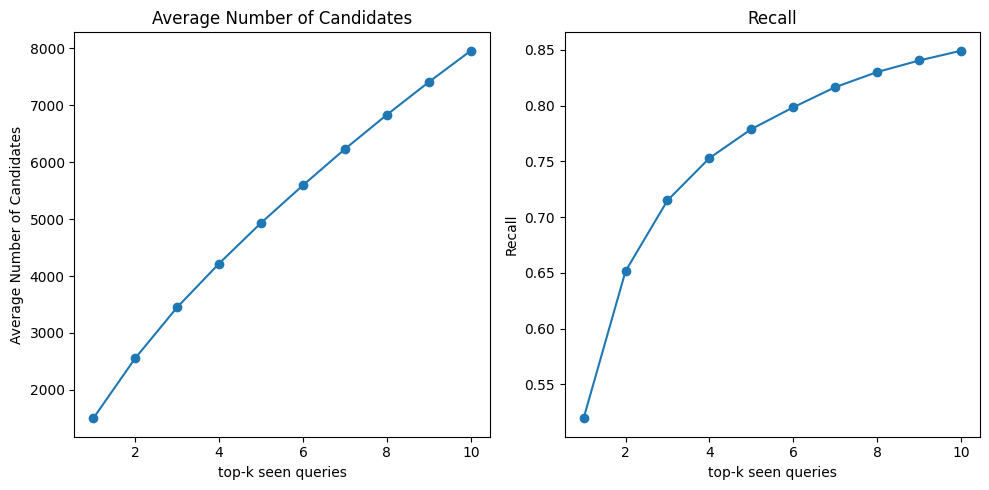

In [39]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_values, avg_num_cand_values, marker='o')
plt.title('Average Number of Candidates')
plt.xlabel('top-k seen queries')
plt.ylabel('Average Number of Candidates')

plt.subplot(1, 2, 2)
plt.plot(x_values, recall_values, marker='o')
plt.title('Recall')
plt.xlabel('top-k seen queries')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()